# Simple Regression

First we load the data

In [181]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import StandardScaler

# Load the dataset
df = pd.read_pickle("../data/winequality.pkl")

df["chlorides"] = np.log1p(df["chlorides"])  # log1p(x) = log(1+x) to avoid log(0)
df[["chlorides", "alcohol"]] = StandardScaler().fit_transform(df[["chlorides", "alcohol"]])

In order to estimate a simple linear regression model, we implement gradient descent from scratch. This optimization algorithm iteratively updates the model parameters by moving them in the direction of the steepest descent of the cost function (mean squared error in this case). The function below accepts a feature matrix $X$, a target vector $y$, and hyperparameters such as the learning rate and number of iterations. It returns the estimated parameters $\theta$ (including the intercept) along with the mean squared error at each iteration, which can be useful for debugging or convergence analysis.

In [182]:
import numpy as np

def gradient_descent(X, y, learning_rate=0.01, n_iterations=1000, random_state=None):
    """
    Performs linear regression using gradient descent.

    Parameters
    ----------
    X : ndarray, shape (m, n)
        Feature matrix (without bias term).
    y : ndarray, shape (m, 1)
        Target vector.
    learning_rate : float, optional (default=0.01)
        Step size for gradient updates.
    n_iterations : int, optional (default=1000)
        Number of iterations.
    random_state : int or None, optional (default=None)
        Seed for reproducibility.

    Returns
    -------
    theta : ndarray, shape (n+1, 1)
        Estimated parameters including bias term.
    history : list
        Mean squared error at each iteration (useful for debugging).
    """
    m, n = X.shape

    # Add bias column
    X_b = np.c_[np.ones((m, 1)), X]

    # Reproducibility
    rng = np.random.default_rng(random_state)
    theta = rng.standard_normal((n + 1, 1))

    history = []

    for _ in range(n_iterations):
        y_pred = X_b @ theta
        error = y_pred - y

        # Gradients
        gradients = (2 / m) * X_b.T @ error

        # Update parameters
        theta -= learning_rate * gradients

        # Track MSE
        mse = np.mean(error**2)
        history.append(mse)

    return theta, history

We now apply the gradient descent implementation to a specific feature–chlorides–to predict wine quality. The feature vector is reshaped into a column format, while the target variable is the wine quality scores. By running gradient descent with a fixed random seed, we obtain the estimated regression parameters (intercept and slope). These coefficients describe the linear relationship between the chloride concentration and wine quality.

In [183]:
# Feature: chlorides (reshaped into column vector)
X = df['chlorides'].values.reshape(-1, 1)
# Target: quality
y = df['quality'].values.reshape(-1, 1)

# Run gradient descent (default lr=0.01, n_iterations=1000)
theta_chlorides, history = gradient_descent(X, y, random_state=42)

print("Theta (intercept, slope):")
print(theta_chlorides.ravel())  # flatten to make it readable

Theta (intercept, slope):
[ 5.65704286 -0.10482083]


Next, we repeat the gradient descent procedure using alcohol content as the predictor variable for wine quality. Since alcohol shows a stronger correlation with quality compared to chlorides, we adjust the learning rate and increase the number of iterations to ensure stable convergence. The resulting coefficients (intercept and slope) quantify the linear relationship between alcohol level and wine quality.

In [184]:
# Feature: alcohol (reshaped into column vector)
X = df['alcohol'].values.reshape(-1, 1)

# Target: quality
y = df['quality'].values.reshape(-1, 1)

# Run gradient descent (default lr=0.01, n_iterations=1000)
theta_alcohol, history = gradient_descent(X, y, learning_rate=0.001, n_iterations=10_000, random_state=42)

print("Theta (intercept, slope):")
print(theta_alcohol.ravel())

Theta (intercept, slope):
[5.65704286 0.39054599]


Lastly, to visually assess the relationship between individual features and wine quality, we plot scatter plots of the data along with the fitted regression lines obtained from gradient descent.
- The first plot shows chlorides vs. quality, where the negative slope indicates that higher chloride content is associated with slightly lower wine quality.
- The second plot shows alcohol vs. quality, where the positive slope suggests that higher alcohol content is correlated with higher wine quality.

These visualizations help illustrate the linear trends captured by our simple regression models and provide an intuitive understanding of the feature–target relationships before further evaluation.

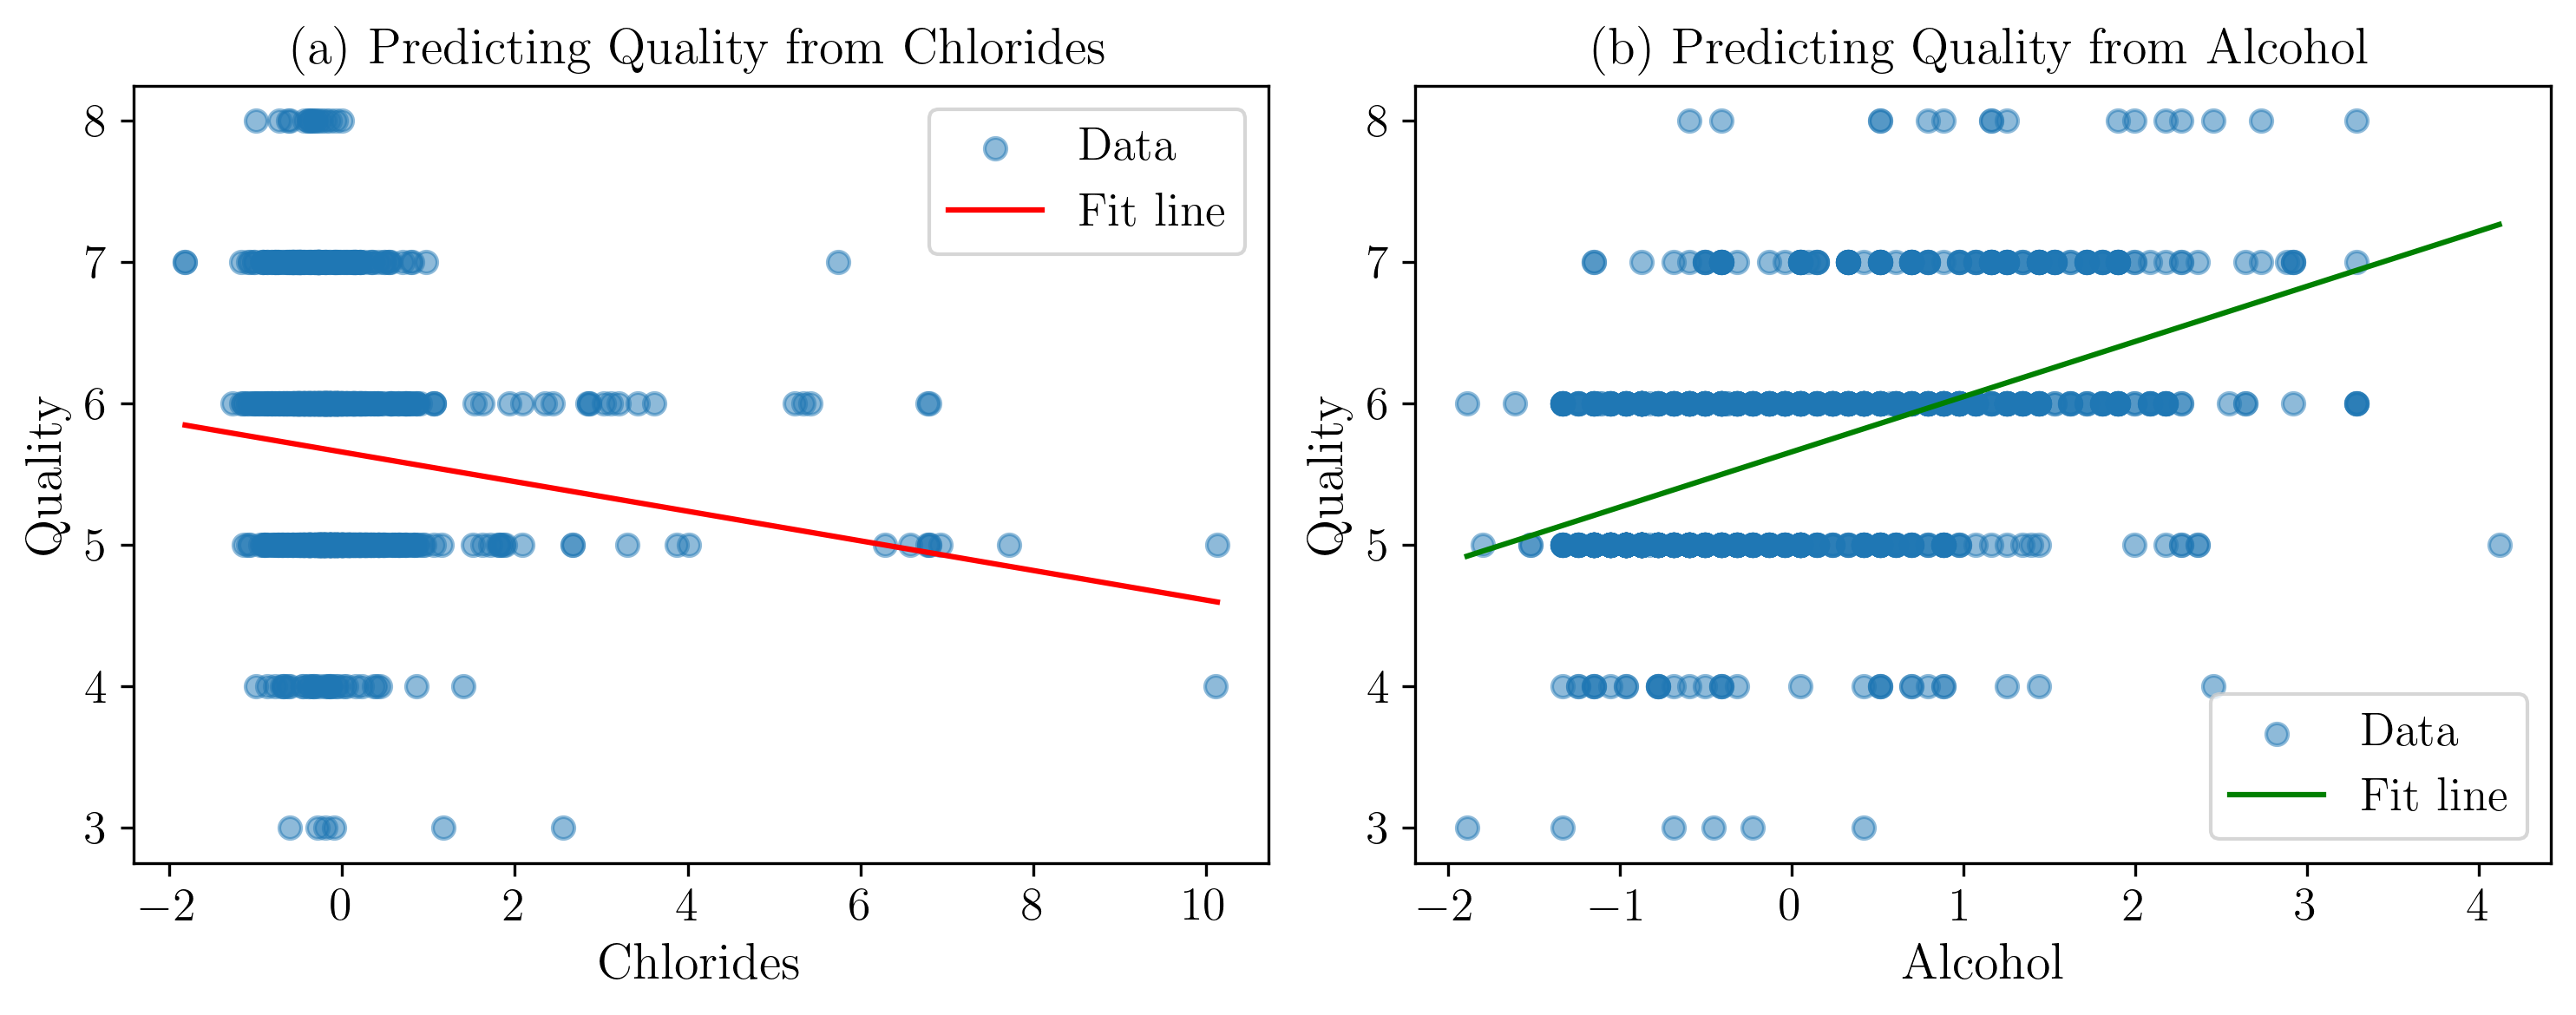

In [185]:
import matplotlib.pyplot as plt

# Chlorides vs Quality
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(df["chlorides"], df["quality"], alpha=0.5, label="Data")
x_vals = np.linspace(df["chlorides"].min(), df["chlorides"].max(), 100)
y_vals = theta_chlorides[0] + theta_chlorides[1]*x_vals
plt.plot(x_vals, y_vals, color="red", label="Fit line")
plt.xlabel("Chlorides")
plt.ylabel("Quality")
plt.title("(a) Predicting Quality from Chlorides")
plt.legend()

# Alcohol vs Quality
plt.subplot(1,2,2)
plt.scatter(df["alcohol"], df["quality"], alpha=0.5, label="Data")
x_vals = np.linspace(df["alcohol"].min(), df["alcohol"].max(), 100)
y_vals = theta_alcohol[0] + theta_alcohol[1]*x_vals
plt.plot(x_vals, y_vals, color="green", label="Fit line")
plt.xlabel("Alcohol")
plt.ylabel("Quality")
plt.title("(b) Predicting Quality from Alcohol")
plt.legend()

plt.rcParams.update({
    "text.usetex": True,                # Use LaTeX for all text
    "font.family": "serif",             # Match your LaTeX font family
    "font.serif": ["New PX"],           # newpxtext/newpxmath font
    "axes.labelsize": 14,               # Size of axis labels
    "axes.titlesize": 14,               # Size of titles
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
    "figure.dpi": 300,                  # High resolution
})

plt.tight_layout()
plt.savefig("../reports/figures/simple_regression.png", 
            bbox_inches="tight",   # don't cut off labels/titles
            dpi=300)               # optional: higher resolution
plt.show()

In [186]:
# Calculate MSE and RMSE

def calculate_mse_rmse(X, y, theta) -> tuple:
    """
    Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE).
    """
    m = X.shape[0]
    X_b = np.c_[np.ones((m, 1)), X]  # Add bias term
    y_pred = X_b @ theta
    error = y_pred - y
    mse = np.mean(error**2)
    rmse = np.sqrt(mse)
    return mse, rmse

# Chlorides
X_chlorides = df['chlorides'].values.reshape(-1, 1)
y = df['quality'].values.reshape(-1, 1)
mse_chlorides, rmse_chlorides = calculate_mse_rmse(X_chlorides, y, theta_chlorides)
print(f"Chlorides - MSE: {mse_chlorides:.4f}, RMSE: {rmse_chlorides:.4f}")

# Alcohol
X_alcohol = df['alcohol'].values.reshape(-1, 1)
mse_alcohol, rmse_alcohol = calculate_mse_rmse(X_alcohol, y, theta_alcohol)
print(f"Alcohol - MSE: {mse_alcohol:.4f}, RMSE: {rmse_alcohol:.4f}")

Chlorides - MSE: 0.6378, RMSE: 0.7986
Alcohol - MSE: 0.4963, RMSE: 0.7045
